## 이미지 식별 머신을 위한 데이터를 준비한다.

필요한 라이브러리를 준비한다.

In [27]:
import matplotlib.pyplot as plt 
import numpy as np 
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms, models
from PIL import Image
%matplotlib inline
%config InineBackend.figure_format = 'retina'


In [28]:
import random
def set_seed(sedd):
    random.seed(sedd)
    np.random.seed(sedd)
    torch.manual_seed(sedd)
    torch.cuda.manual_seed_all(sedd)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [29]:
data_dir = './data'
valid_size = 0.2

t_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize(224),
    transforms.ToTensor()
])


In [30]:
print(t_transform)

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [31]:
train_data = datasets.ImageFolder(data_dir, transform = t_transform)
test_data  = datasets.ImageFolder(data_dir, transform= t_transform)
print(train_data)

Dataset ImageFolder
    Number of datapoints: 155
    Root location: ./data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [32]:
num_train = len(train_data)
indices = list(range(num_train))
print(indices)

np.random.shuffle(indices)
print(indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
[81, 142, 31, 29, 118, 60, 93, 147, 153, 68, 42, 138, 78, 75, 15, 19, 30, 90, 117, 137, 18, 12, 9, 24, 69, 131, 95, 45, 86, 84, 126, 96, 122, 82, 109, 65, 51, 26, 133, 76, 56, 36, 124, 22, 55, 85, 11, 141, 66, 119, 27, 79, 144, 41, 4, 32, 134, 143, 67, 16, 123, 10, 113, 146, 101, 0, 110, 64, 44, 97, 28, 40, 104, 25, 23, 108, 39, 151

In [33]:
split = int(np.floor(num_train*valid_size))
print(split)

31


In [34]:
train_idx, test_idx = indices[split:], indices[:split]
print(train_idx)
print(test_idx)

[96, 122, 82, 109, 65, 51, 26, 133, 76, 56, 36, 124, 22, 55, 85, 11, 141, 66, 119, 27, 79, 144, 41, 4, 32, 134, 143, 67, 16, 123, 10, 113, 146, 101, 0, 110, 64, 44, 97, 28, 40, 104, 25, 23, 108, 39, 151, 98, 150, 136, 47, 111, 61, 73, 33, 148, 125, 62, 105, 94, 53, 5, 127, 114, 49, 35, 80, 77, 34, 46, 7, 43, 70, 112, 91, 83, 139, 140, 89, 8, 13, 59, 132, 3, 17, 38, 72, 135, 6, 128, 100, 2, 120, 63, 115, 54, 107, 50, 152, 58, 48, 88, 21, 57, 149, 129, 37, 145, 1, 52, 130, 103, 99, 116, 87, 74, 121, 154, 20, 71, 106, 14, 92, 102]
[81, 142, 31, 29, 118, 60, 93, 147, 153, 68, 42, 138, 78, 75, 15, 19, 30, 90, 117, 137, 18, 12, 9, 24, 69, 131, 95, 45, 86, 84, 126]


In [35]:
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, sampler=test_sampler)

print(train_loader.dataset.classes)
print(test_loader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


## Load_Split_Train_Test() 함수를 이용하여 train_loader, test_loader를 각각 생성한다.

In [36]:
def load_split_train_test(data_dir, valid_size):
    t_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor()
    ])
    
    train_data = datasets.ImageFolder(data_dir, transform=t_transform)
    num_train = len(train_data)
    indices = list(range(num_train))
    
    np.random.shuffle(indices)
    split = int(np.floor(num_train * valid_size))
    
    train_idx, test_idx = indices[split:], indices[:split]
    
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(train_data, batch_size=16, sampler=test_sampler)
    
    return train_loader, test_loader

In [37]:
train_loader, test_loader  = load_split_train_test(data_dir, valid_size)

print(train_loader.dataset.classes)
print(test_loader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


In [38]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=t_transform)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, batch_size=num, sampler=sampler)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

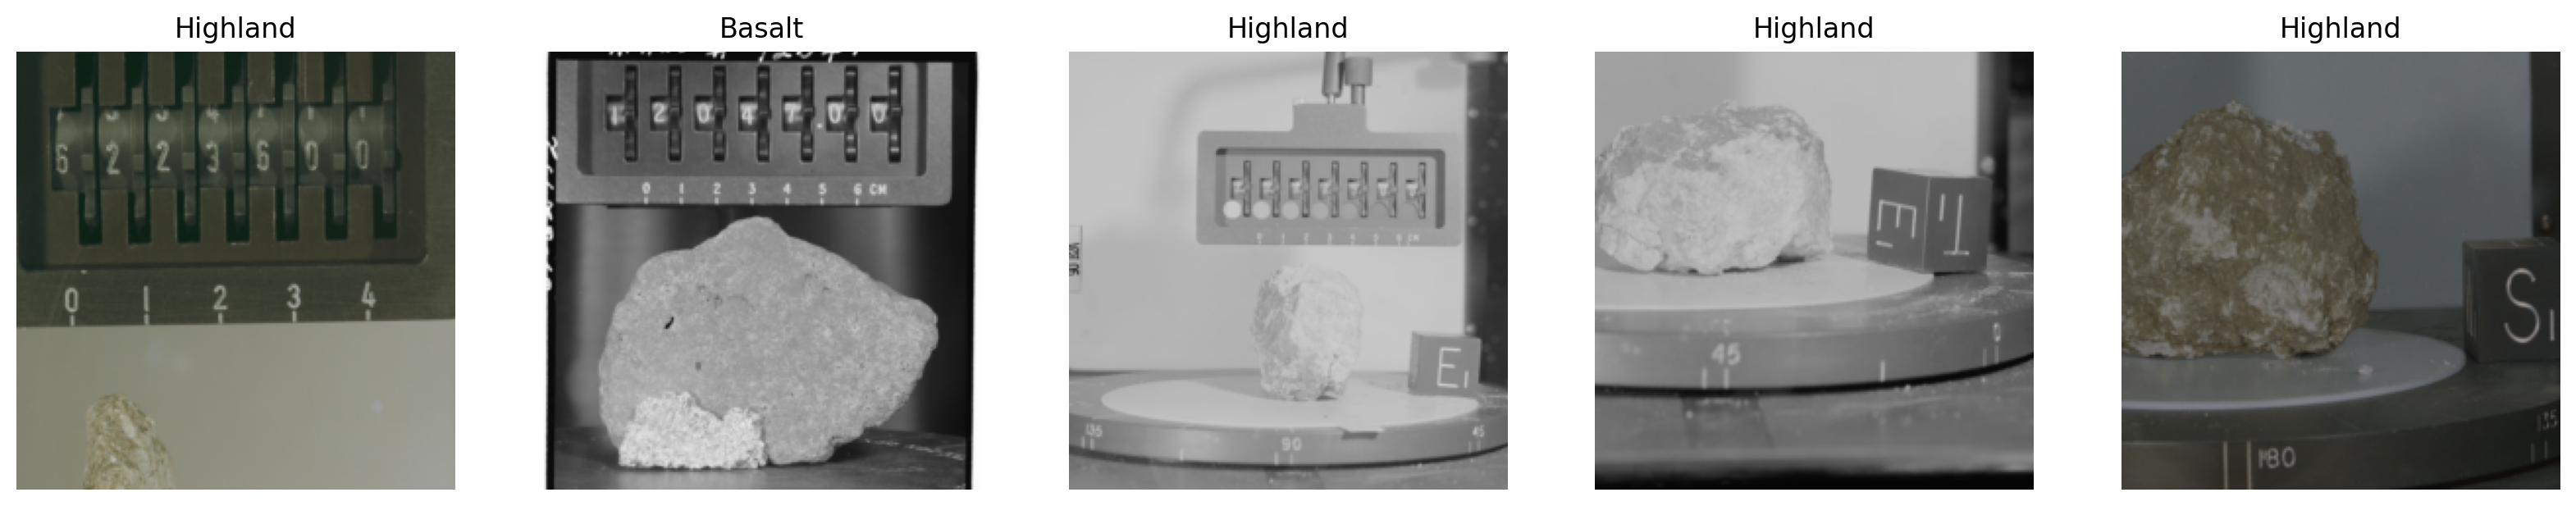

In [39]:
images, labels = get_random_images(5)
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20, 20))
classes = train_loader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii + 1)
    index = labels[ii].item()
    sub.set_title(classes[index])
    plt.axis('off')
    plt.imshow(image)
plt.show()


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [41]:
model = models.resnet50(pretrained=True)

/workspaces/spacerocks/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/workspaces/spacerocks/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential(nn.Linear(2048,512),
                     nn.ReLU(),
                     nn.Dropout(0.2),
                     nn.Linear(512,2),
                        nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model = model.to(device)
print('done!')



done!


In [44]:
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)


In [45]:
epochs = 10
print_every = 5
running_loss = 0
train_losses, test_losses = [], []
steps = 0

In [46]:
# 설정한 회수만큼 학습 후 테스트 및 평가해 본다.
for epoch in range(epochs) :
    # 에폭을 count 한다.
    epoch += 1
    # trainloader로부터 모든 이미지와 레이블을 로드한다.
    for inputs, labels in train_loader:
        # 학습 단계를 count 하고 출력한다.
        steps += 1
        print('Training step ', steps)
        # 입력 데이터(이미지, 레이블)를 device로 보낸다.
        inputs, labels = inputs.to(device), labels.to(device)
        # 기존에 학습된 gradient 값을 초기화 한다.(이전에 학습한 값이 영향을 주지 않도록 함)
        optimizer.zero_grad()
        # 입력 데이터로 순전파를 수행하고 로그 확률을 얻는다.
        logps = model.forward(inputs)
        # 손실(loss) 값들을 계산한다.
        loss = criterion(logps, labels)
        # 손실값을 이용하여 gradient를 update한다.
        loss.backward()
        # gradient를 이용하여 설정된 optimizer로 파라미터를 update한다.
        optimizer.step()
        # 손실값을 누적/계산한다.
        running_loss += loss.item()
        # 학습 단계 5회마다 모델을 테스트/평가 한다.
        if steps % print_every == 0:
            # 손실과 정확도 변수를 초기화 한다.
            test_loss = 0
            accuracy = 0
            # 모델 평가 모드로 전환한다.
            model.eval()
            # 모델 평가 시 gradient를 계산하지 않도록 한다.
            with torch.no_grad():
                # testloader로부터 모든 이미지와 레이블을 로드한다.
                for inputs, labels in test_loader:
                    # 입력 데이터(이미지, 레이블)를 device로 보낸다.
                    inputs, labels = inputs.to(device), labels.to(device)
                    # 입력 데이터로 순전파를 수행하고 로그 확률을 얻는다.
                    logps = model.forward(inputs)
                    # 손실(loss) 값들을 계산한다.
                    batch_loss = criterion(logps, labels)
                    # 손실값을 누적시킨다.
                    test_loss += batch_loss.item()
                    # 로그 확률로부터 진짜 확률값을 계산한다.
                    ps = torch.exp(logps)
                    # 가장 큰 확률값과 class를 얻는다. (topk : k번째로 큰 값)
                    top_p, top_class = ps.topk(1, dim=1)
                    # 레이블들을 top_class와 동일한 형태로 바꾼 후 같은 값들을 얻는다.
                    equals = top_class == labels.view(*top_class.shape)
                    # equals를 float 텐서로 바꾼 후 평균 정확도를 누적/계산한다.
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            # 학습 손실값과 테스트 손실값을 추가한다.
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))
            # 학습 손실값, 테스트 손실값, 테스트 정확도를 출력한다.
            print("Epoch {}/{}: ".format(epoch, epochs),
                  "Train loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test loss: {:.3f}.. ".format(test_loss/len(test_loader)),
                  "Test accuracy: {:.3f}\n".format(accuracy/len(test_loader))) 
            # running_loss 값을 초기화 한다.
            running_loss = 0
            # 모델 학습 모드로 전환한다.
            model.train()
            break

Training step  1
Training step  2
Training step  3
Training step  4
Training step  5
Epoch 1/10:  Train loss: 2.679..  Test loss: 2.702..  Test accuracy: 0.579

Training step  6
Training step  7
Training step  8
Training step  9
Training step  10
Epoch 2/10:  Train loss: 2.623..  Test loss: 1.944..  Test accuracy: 0.417

Training step  11
Training step  12
Training step  13
Training step  14
Training step  15
Epoch 3/10:  Train loss: 1.198..  Test loss: 1.175..  Test accuracy: 0.577

Training step  16
Training step  17
Training step  18
Training step  19
Training step  20
Epoch 4/10:  Train loss: 0.873..  Test loss: 0.269..  Test accuracy: 0.935

Training step  21
Training step  22
Training step  23
Training step  24
Training step  25
Epoch 5/10:  Train loss: 0.637..  Test loss: 0.582..  Test accuracy: 0.577

Training step  26
Training step  27
Training step  28
Training step  29
Training step  30
Epoch 6/10:  Train loss: 0.342..  Test loss: 0.408..  Test accuracy: 0.744

Training step

KeyboardInterrupt: 

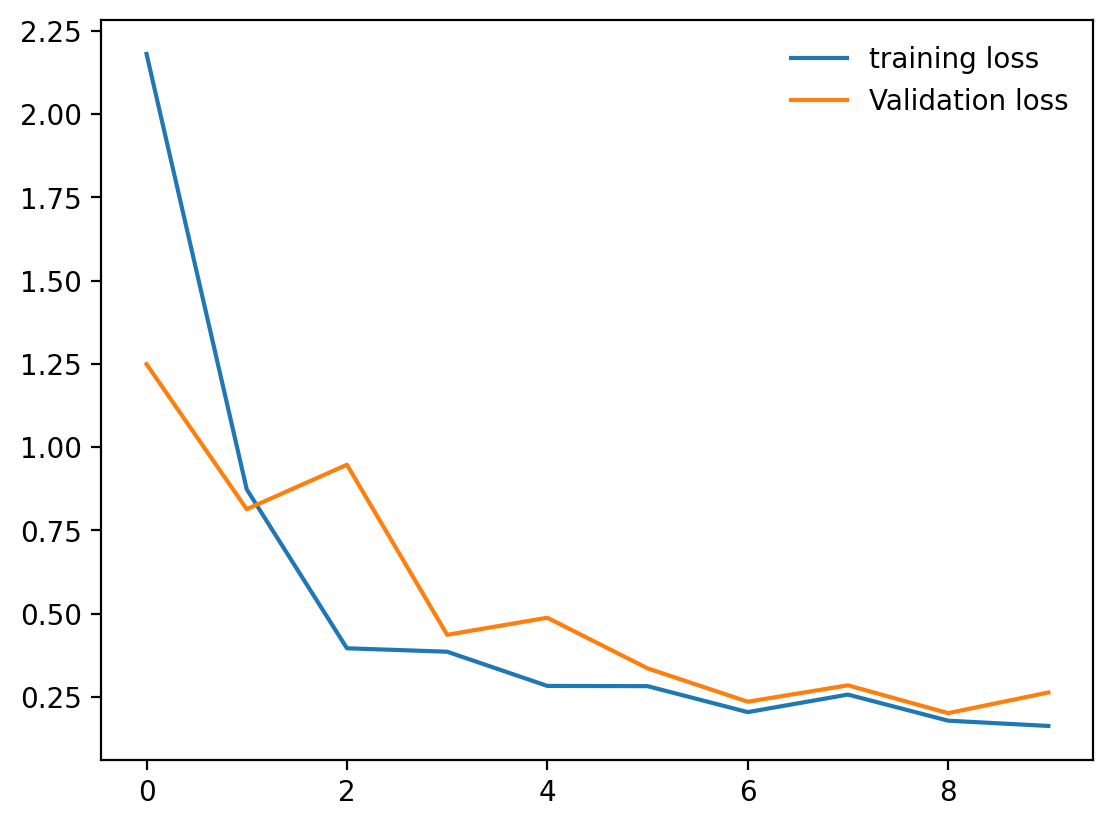

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
torch.save(model, 'modelrockmodel.pth')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('modelrockmodel.pth')
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def predict_image(image):
    image_tensor = t_transform(image).float()
    input = image_tensor.unsqueeze_(0)
    input = input.to(device)
    output = model(input)
    index = output.data.numpy().argmax()
    return index

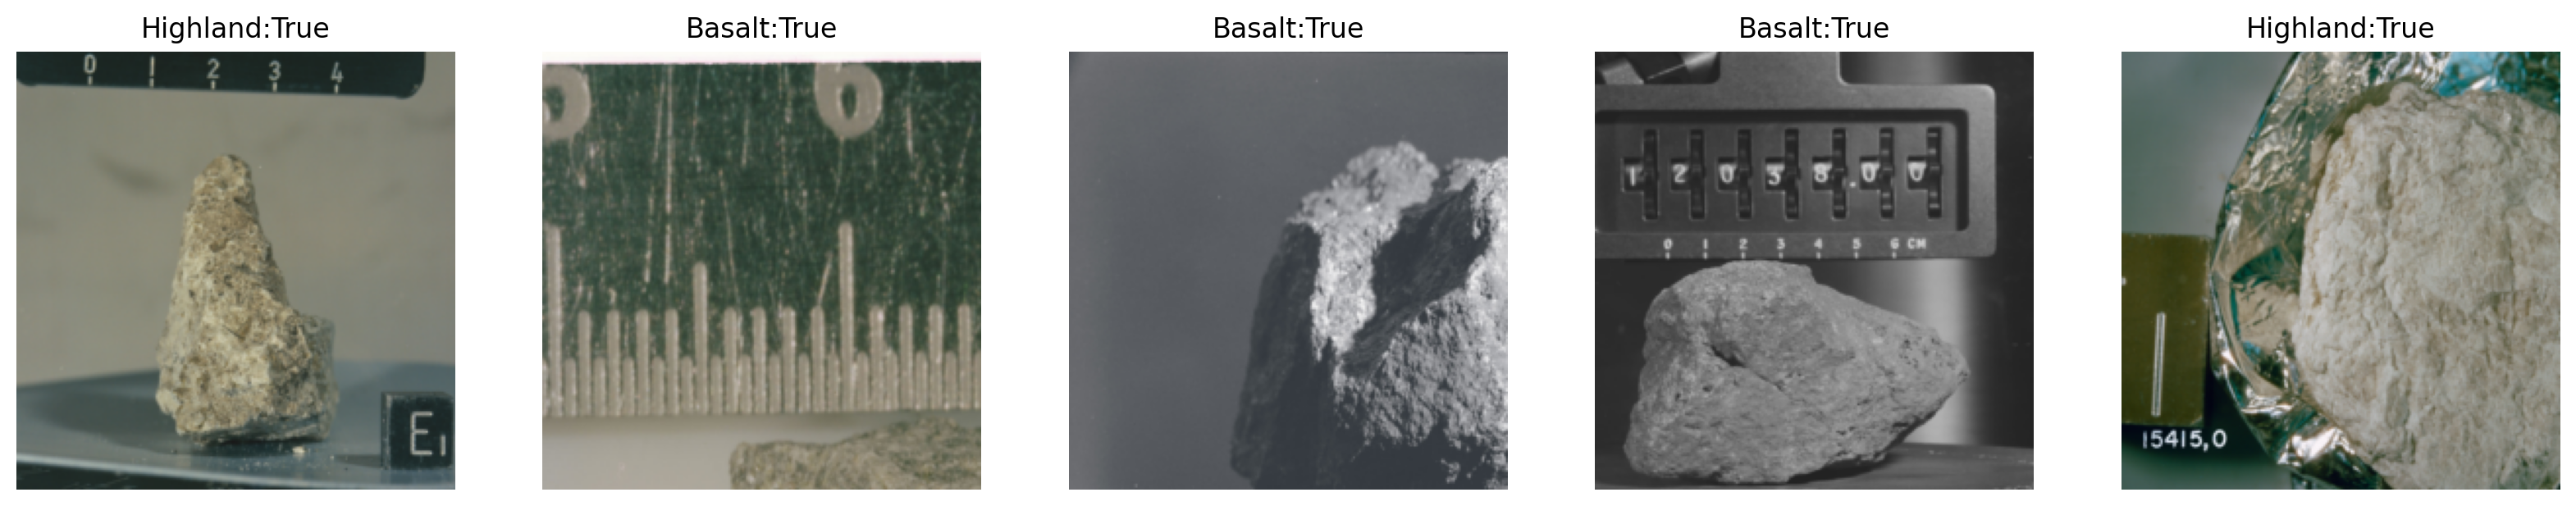

In [ ]:
model.eval()

to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig = plt.figure(figsize=(20, 20))
classes = train_loader.dataset.classes

for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii + 1)
    index = predict_image(image)
    res = labels[ii].item() == index
    sub.set_title(classes[index] + ':' + str(res))
    plt.axis('off')
    plt.imshow(image)
    
plt.show()